In [2]:
# import
import csv
import math
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

## cluster
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)


%matplotlib inline

random.seed

<bound method Random.seed of <random.Random object at 0x10402c618>>

In [6]:
# for floor in range(0,5):
#     for building in range(0,3):
for floor in range(2,3):
    for building in range(0,1):
#        kernel =  Matern(length_scale=100)
#         kernel = 2.0 * RationalQuadratic(length_scale=0.08, alpha=2.1) + 1.0*RBF(length_scale=100)
#         kernel = 1.2 * RationalQuadratic(length_scale=0.08, alpha=2.1) + 0.1*RBF(length_scale=100)
        kernel = 1.4 * RationalQuadratic(length_scale=0.08, alpha=2.1) + 1.0*ExpSineSquared(length_scale = 50, periodicity=1)
#         kernel = 1.0 * RationalQuadratic(length_scale=0.08, alpha=2.1) + ExpSineSquared(length_scale = 50, periodicity=1)
#         kernel =  RBF(length_scale=100)
#         kernel = ExpSineSquared(length_scale = 50, periodicity=1)
        
        ## Count the number of data points in building id & floor id
        data_num = 0
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num += 1
        print(data_num)
        ## if there are no data, continue to next floor 
        if (data_num == 0):
            continue
            
        ## Load data points in
        wifi_loc_time = np.zeros(shape = (data_num, 524))
        i=-1
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i = i+1
                if (i > data_num):
                    break
                # wifi
                wifi_loc_time[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time[i-1][-1] = np.array(row[-1])
        
        ## Sort by time stamp
        wifi_loc_time = wifi_loc_time[wifi_loc_time[:,-1].argsort()]
        
        ## List all users
        user_list = np.unique(wifi_loc_time[:, 522])
        user_num = len(user_list)
        print("On floor ", floor, " in building ", building, "there are ", user_num, " users.")
        
        ## Record each user's number of location logs
        user_walking_num = np.zeros(shape=(user_num), dtype=int)
        for i in range(len(wifi_loc_time[:,522])):
            for user_index in range(user_num):
                if (wifi_loc_time[i, 522] == user_list[user_index]):
                    user_walking_num[user_index] += 1
        
        ## set the sequence length of observed walking tracks
        seq_window = 9
        total_batch_num = 0
        
        ## compute all users' walking sequences and add them as number of batches
        for num in user_walking_num:
            total_batch_num += math.floor(num/seq_window)
        print("total_batch_num: ",total_batch_num)
        
        batch_wifi = np.zeros((total_batch_num, seq_window, 520))
        batch_loc = np.zeros((total_batch_num, seq_window), dtype = int)
        
        ## tracking parameters
        state_count = 0
        ## cumulative graduation [# of batch of user1] + [# of batch of user2] [...]
        batch_num = 0
        iter_batch = 0
        iter_window = 0
        state_map_grid = {}
        
        ## Clustering K-means
        grids = 2
        kmeans = KMeans(n_clusters = grids, random_state=0).fit(wifi_loc_time[:, 520:522])
        centers = kmeans.cluster_centers_
        states = np.zeros(shape=(grids,1), dtype=int)
        states_pred = np.zeros(shape=(grids,1), dtype=int)
        
        for i in range(grids):
            states[i] = -1
            states_pred[i] = -1
            
        ## define states
        for k in range(len(user_list)):
            for i in range(len(wifi_loc_time[:,522])):
                if (wifi_loc_time[i, 522] == user_list[k]):
                    if (states_pred[kmeans.labels_[i]] == -1):
                        states_pred[kmeans.labels_[i]] = state_count
                        state_count += 1
                    
        state_count = 0
        
        for k in range(len(user_list)):
            print("User",k, " walking ", user_walking_num[k])
            
            ## [longitude, latitude, wifi]
            batch_num += math.floor(user_walking_num[k]/seq_window)
            
            ## pick out the corresponding user's data
            for i in range(len(wifi_loc_time[:,522])):
                if (wifi_loc_time[i, 522] == user_list[k]):
                    batch_wifi[iter_batch][iter_window] = np.array(wifi_loc_time[i, :520])
                    if (states[kmeans.labels_[i]] == -1):
                        gp = GaussianProcessRegressor(kernel=kernel,
                                          alpha=0.5)
                        states[kmeans.labels_[i]] = state_count
                        grid_wifi_data = batch_wifi[iter_batch][iter_window]
                        grid_loc_data = np.array([wifi_loc_time[i, 520] - centers[kmeans.labels_[i], 0]\
                                                  , wifi_loc_time[i, 521] - centers[kmeans.labels_[i], 1] ])
                        label = kmeans.labels_[i]
#                         grid_loc_data = np.array([wifi_loc_time[i, 520]\
#                                                    , wifi_loc_time[i, 521]])
                        state_map_grid[state_count] = [gp, grid_wifi_data, grid_loc_data, label]
                        state_count += 1
                    else:
                        state_map_grid[int(states[kmeans.labels_[i]])][1] = np.vstack((state_map_grid[int(states[kmeans.labels_[i]])][1], batch_wifi[iter_batch][iter_window]))
                        state_map_grid[int(states[kmeans.labels_[i]])][2] = np.vstack((state_map_grid[int(states[kmeans.labels_[i]])][2], \
                                   np.array([wifi_loc_time[i, 520] - centers[kmeans.labels_[i], 0]\
                                             , wifi_loc_time[i, 521] - centers[kmeans.labels_[i], 1]] )))
#                         state_map_grid[int(states[kmeans.labels_[i]])][2] = np.vstack((state_map_grid[int(states[kmeans.labels_[i]])][2], \
#                                    np.array([wifi_loc_time[i, 520]\
#                                              , wifi_loc_time[i, 521]] )))
                        
                    batch_loc[iter_batch,iter_window] = states[kmeans.labels_[i]]
                
                    if (iter_window == (seq_window-1)):
                        iter_window = 0
                        iter_batch = iter_batch + 1
                        if (iter_batch == (batch_num)):
                            break
                    else:
                        iter_window = iter_window + 1                
                    
                
        print("# of grids is ", grids, " ; the # of states is ", state_count)
        for s in range(state_count):
            print("State ", s, "; data points: ", state_map_grid[s][2].shape)
            state_map_grid[s][0] = state_map_grid[s][0].fit(state_map_grid[s][1], state_map_grid[s][2])
                    
################## Testing #####################################################################################
        # extract data
        print("Validation...")
        data_num_v = 0
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num_v += 1

        print(data_num_v)
        if (data_num_v == 0):
            continue
        i = -1
        wifi_loc_time_v = np.zeros(shape = (data_num_v, 524))
        
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i += 1
                #if (i > data_num):
                #    break
                # wifi
                wifi_loc_time_v[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time_v[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time_v[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time_v[i-1][-1] = np.array(row[-1])
                
        wifi_loc_time_v = wifi_loc_time_v[wifi_loc_time_v[:,-1].argsort()]  
                
        batch_num = int(data_num_v/seq_window)
        print("Validating data ", batch_num)
        batch_wifi_v = np.zeros((batch_num + 1, seq_window, 520))
        batch_loc_v = np.zeros((batch_num + 1, seq_window), dtype = int)

        iter_window = 0
        iter_batch = 1

        ## Clustering data points by their longitude & latitude ##
        for s in range(len(wifi_loc_time_v)):
            state_pred = kmeans.predict(wifi_loc_time_v[s][520:522].reshape(1,2))
            batch_loc_v[iter_batch,iter_window] = states[state_pred[0]]
            
            batch_wifi_v[iter_batch][iter_window] = wifi_loc_time_v[s][:520]
            if (iter_window == (seq_window-1)):
                iter_window = 0
                iter_batch = iter_batch + 1
                if (iter_batch == (batch_num)):
                    break
            else:
                iter_window = iter_window + 1
                
        model = ChainCRF()
        ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=80)            
        ssvm.fit(batch_wifi, batch_loc)
        
        pred_batch_v = ssvm.predict(batch_wifi_v)
        total_error = 0

        center_longitude_pred = 0
        center_latitude_pred = 0
        center_longitude_gt = 0
        center_latitude_gt = 0
        
        real_longitude = 0
        real_latitude = 0

        iter_test = 0
        
        window = np.zeros((seq_window))
        
        error_list = []
        result_lo = []
        result_la = []
        
        gp_total_error = 0
        gp_window = np.zeros((seq_window))
        
        for i in range(1,batch_num+1):
            for j in range(seq_window):
                ans = state_map_grid[int(pred_batch_v[i][j])][0].predict(batch_wifi_v[i][j].reshape(1,520))
                
                center_longitude_pred = centers[pred_batch_v[i][j], 0]
                center_latitude_pred = centers[pred_batch_v[i][j], 1]
                center_longitude_gt = centers[batch_loc_v[i][j], 0]
                center_latitude_gt = centers[batch_loc_v[i][j], 1]
#                 center_longitude_pred = 0
#                 center_latitude_pred = 0
#                 center_longitude_gt = 0
#                 center_latitude_gt = 0
                
#                 print("\nGrid box: ", i, j)
#                 print("Predict grid ", states[pred_batch_v[i][j]], "; Gt grid ", states[batch_loc_v[i][j]])
#                 print("longitude ", center_longitude_pred, center_longitude_gt)
#                 print("latitude ", center_latitude_pred, center_latitude_gt)
                
#                 print(ans[0][0], ans[0][1])
#                 print("Add...")
                ans[0][0] += center_longitude_pred
                ans[0][1] += center_latitude_pred
                result_lo.append(ans[0][0])
                result_la.append(ans[0][1])
                real_longitude = wifi_loc_time_v[iter_test][520]
                real_latitude = wifi_loc_time_v[iter_test][521]
#                 print("predict: ", ans[0][0], ans[0][1])
#                 print("real: ", real_longitude, real_latitude)
#                 print("RMSE: ", math.sqrt(pow(ans[0][0] - real_longitude,2) + pow(ans[0][1] - real_latitude,2)))
                error_list.append(math.sqrt(pow(ans[0][0] - real_longitude,2) + pow(ans[0][1] - real_latitude,2)))
                gp_total_error += math.sqrt(pow(ans[0][0] - real_longitude,2) + pow(ans[0][1] - real_latitude,2))
                gp_window[j] += math.sqrt(pow(ans[0][0] - real_longitude,2) + pow(ans[0][1] - real_latitude,2))
                
                iter_test+=1
                
                total_error += math.sqrt(pow(center_longitude_pred - center_longitude_gt,2)+pow(center_latitude_pred - center_latitude_gt,2))
                            
                window[j] += math.sqrt(pow(center_longitude_pred - center_longitude_gt,2)+pow(center_latitude_pred - center_latitude_gt,2))
                

        print("\nbox\nRMSE: ", total_error/(batch_num*seq_window))
        print("Windows:")
        for x in range(seq_window):
            print(" ", x, window[x]/batch_num)
        print("gp")
        print("RMSE: ", gp_total_error/(batch_num*seq_window))
        print("Windows:")
        for x in range(seq_window):
            print(" ", x, gp_window[x]/batch_num)
        print("Finish\n")

1443
On floor  2  in building  0 there are  2  users.
total_batch_num:  159
User 0  walking  733
User 1  walking  710
# of grids is  2  ; the # of states is  2
State  0 ; data points:  (687, 2)
State  1 ; data points:  (744, 2)
Validation...
165
Validating data  18

box
RMSE:  0.43519292992085606
Windows:
  0 0.0
  1 0.0
  2 0.0
  3 0.0
  4 0.0
  5 0.0
  6 0.0
  7 0.0
  8 3.9167363692877046
gp
RMSE:  9.379289186485764
Windows:
  0 9.095940676039318
  1 8.512081511355044
  2 8.246607887456982
  3 10.770543426444242
  4 9.48748026447771
  5 10.847401859646784
  6 9.543718025758617
  7 8.908585338988185
  8 9.00124368820502
Finish



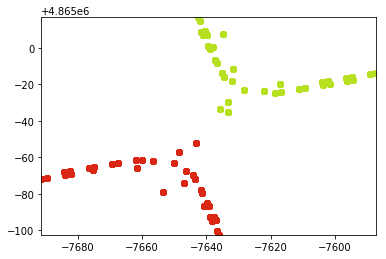

<Figure size 432x288 with 0 Axes>

In [7]:
color = ['#da2614', '#b7e020', '#f16ce5', '#169fe3', '#F5FC26', '#17C32C', '#0626EF', '#E579B1', '#705C5A']
axes = plt.gca()
axes.set_xlim([min(wifi_loc_time[:,520]),max(wifi_loc_time[:,520])])
axes.set_ylim([min(wifi_loc_time[:,521]),max(wifi_loc_time[:,521])])
for i in range(len(wifi_loc_time)):    
    plt.scatter(wifi_loc_time[i,520], wifi_loc_time[i,521], c=color[kmeans.labels_[i]], marker='o')
# i=0
# a=0.7
# for j in range(len(error_list)):
#     pred = kmeans.predict(wifi_loc_time_v[j][520:522].reshape(1,2))
#     if (error_list[j] > 10):
#         if (i==0):
#             plt.scatter(wifi_loc_time_v[j,520], wifi_loc_time_v[j,521], c=color[2*grids+pred[0]], marker='*', label='gt', alpha=a)
#             plt.scatter(result_lo[j], result_la[j], c=color[grids+pred[0]], marker='x', label='predict', alpha=a)
#         else:
#             plt.scatter(wifi_loc_time_v[j,520], wifi_loc_time_v[j,521], c=color[2*grids+pred[0]], marker='*', alpha=a)
#             plt.scatter(result_lo[j], result_la[j], c=color[grids+pred[0]], marker='x', alpha=a)
#         i += 1
# plt.title("k=2 prediction")
# plt.legend()
# plt.savefig("k2")
plt.show()
plt.clf()

In [7]:
count_bad = 0
for i in range(len(error_list)):
    if (error_list[i] < 10):
        count_bad+=1
print(count_bad)

count_bad = 0
for i in range(len(error_list)):
    if (error_list[i] < 15):
        count_bad+=1
print(count_bad)

count_bad = 0
for i in range(len(error_list)):
    if (error_list[i] < 20):
        count_bad+=1
print(count_bad)

104
130
149


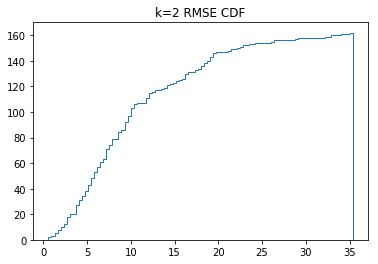

In [52]:
# CDF
n_bins = 100
plt.title("k=2 RMSE CDF")
plt.hist(error_list, bins=n_bins, cumulative=True, histtype='step')
plt.savefig("k2_cdf")

In [24]:
len(error_list)

162